In [1]:
from math import e, factorial,log, gamma, sqrt, floor
from matplotlib import pyplot as pt
from numpy.random import geometric,exponential,poisson
from scipy.stats import ks_2samp
from scipy.stats import norm
from numpy import linspace
from IPython.display import Markdown
from analysis import *
from threading import Thread

In [2]:
pt.rcParams["figure.figsize"] = (20,10)

# Load data

This is a comment


In [3]:
Ttx = 30
Trx = 60
Tn = 100
    
def compute_histogram(r1,r2):

    Eb1,Es1,En1 = computeEvents(r1,Ttx,Trx,Tn)
    Eb2,Es2,En2 = computeEvents(r2,Ttx,Trx,Tn)
    display(Markdown('<span style="color: #af0000">'+"P(S) = %.6f"%(Trx*Es1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #00af00">'+"P(N) = %.6f"%(Tn*En1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #0000af">'+"P(B) = %.6f"%(Ttx*Eb1/len(r1))+'</span>'))

    Pb2 = Eb2*Ttx/(Eb2*Ttx+En2*Tn+Es2*Trx)
    rt1 = Pb2/(Ttx/1000)
    
    print("r(B)(Events/s) = %.6f"%(rt1))
    
    hist1 = genWindowHistogram(r1,r2,1000)
    Esuc = checkSuccess(r2,r1)
    Ps=Esuc/Eb2
    rs2 = Esuc*1000/len(r1)
    print("r(Suuccess)(Events/s) = %.6f"%rs2)
    Pscan = Trx*Es1/len(r1)
    r_scan = 1000*Pscan/Trx
    print("r(S)(Events/s) = %.6f"%r_scan)
    Ns = Ps*1000/Ttx
    Nb = rt1*1000
    print("Success probability evts: %.6f"%(Ps))
    return hist1,Eb1,Es1,En1,Ps

<span style="color: #af0000">P(S) = 0.199867</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.800133</span>

r(B)(Events/s) = 26.647509
0.9999999999999999
r(Suuccess)(Events/s) = 5.333524
r(S)(Events/s) = 3.331116
Success probability evts: 0.200072
0.9693678557499025
---------------------


<span style="color: #af0000">P(S) = 0.299879</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.700121</span>

r(B)(Events/s) = 23.312658
1.0
r(Suuccess)(Events/s) = 6.994184
r(S)(Events/s) = 4.997987
Success probability evts: 0.299886
0.994247988212626
---------------------


<span style="color: #af0000">P(S) = 0.399731</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.600269</span>

r(B)(Events/s) = 19.995350
0.9999999999999998
r(Suuccess)(Events/s) = 7.985475
r(S)(Events/s) = 6.662186
Success probability evts: 0.399265
0.9983197311569851
---------------------


<span style="color: #af0000">P(S) = 0.499251</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.500749</span>

r(B)(Events/s) = 16.641155
1.0
r(Suuccess)(Events/s) = 8.300592
r(S)(Events/s) = 8.320852
Success probability evts: 0.498296
0.9993246792226308
---------------------


<span style="color: #af0000">P(S) = 0.600172</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.399828</span>

r(B)(Events/s) = 13.328023
1.0
r(Suuccess)(Events/s) = 7.988748
r(S)(Events/s) = 10.002867
Success probability evts: 0.599400
0.999416746377995
---------------------


<span style="color: #af0000">P(S) = 0.699866</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.300134</span>

r(B)(Events/s) = 9.989174
1.0
r(Suuccess)(Events/s) = 6.987852
r(S)(Events/s) = 11.664434
Success probability evts: 0.699296
0.9989382448537378
---------------------


<span style="color: #af0000">P(S) = 0.801006</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.198994</span>

r(B)(Events/s) = 6.676405
1.0
r(Suuccess)(Events/s) = 5.343177
r(S)(Events/s) = 13.350099
Success probability evts: 0.801174
0.9934854722033492
---------------------


<span style="color: #af0000">P(S) = 0.899795</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.100205</span>

r(B)(Events/s) = 3.329297
0.9999999999999999
r(Suuccess)(Events/s) = 2.994355
r(S)(Events/s) = 14.996583
Success probability evts: 0.899129
0.950271380372598
---------------------


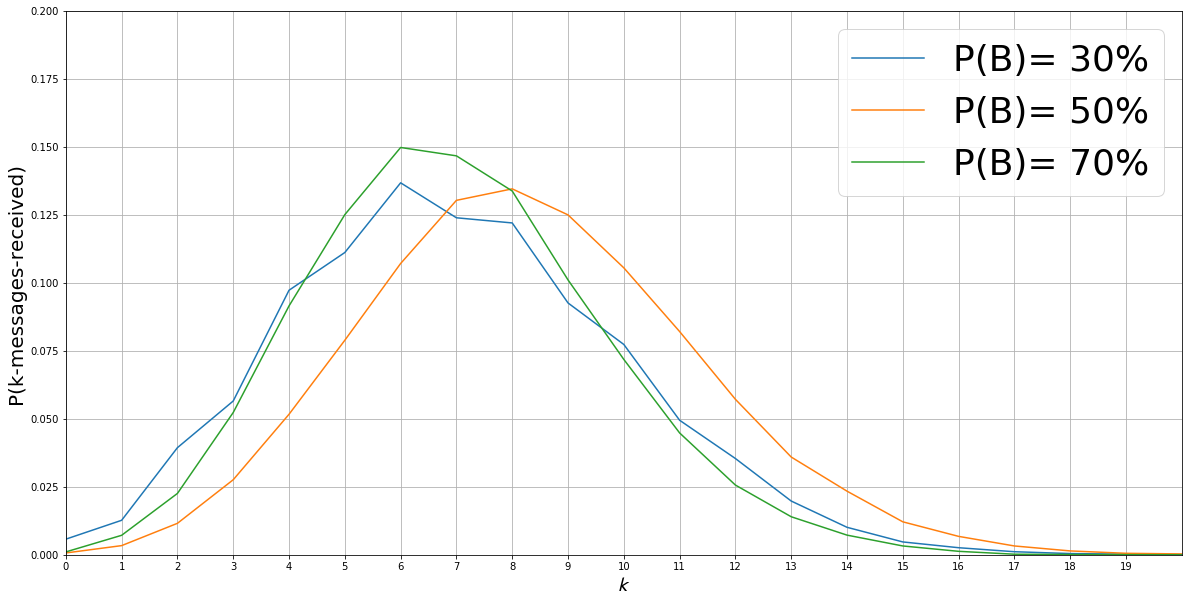

In [4]:
leg = [20,30,40,50,60,70,80,90]
for i in range(1,9):
    f1 = open("r%d-d0-result.txt"%i)
    raw1 = f1.read()
    f1.close()

    f2 = open("r%d-d1-result.txt"%i)
    raw2 = f2.read()
    f2.close()

    hist,Eb,Es,En,Ps = compute_histogram(raw1,raw2)
    print(1-hist[0])
    print('---------------------')
    if (10+i*10) in [30,50,70]:
        pt.plot(range(len(hist)),hist,label="P(B)= %d%%"%(10+i*10))
    del(hist)
    
pt.axis([0,20,0,0.2])
pt.xticks(range(20), [str(n) for n in range(20)])
pt.xlabel(r'$\mathcal{k}$', fontsize = 20)
pt.ylabel(r'P(k-messages-received)', fontsize = 20)
pt.legend(fontsize=36)
pt.grid(True)
pt.savefig('arrival_distribution.pdf',format='pdf',dpi=300, bbox_inches='tight')
pt.show()

In [9]:
evts = {}

for i in range(0,5):
    f1 = open("r4-d%d-result.txt"%i)
    raw1 = f1.read()
    f1.close()
    
    for e in range(len(raw1)):
        if raw1[e] == 'B':
            try:
                evts[e].append(i)
            except:
                evts[e] = [i]
    
for e in evts:
    if len(evts[e])>1:
        print(evts[e])

